# PART ONE
Using Clip Tokenizer only to get embeddings and compare

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import torch.utils.data.dataloader as DataLoader
from fastai.collab import CollabDataLoaders
from fastai.learner import Learner
from tqdm import tqdm
import os
from fastai.losses import MSELossFlat

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, torch.nn as nn
from sklearn.preprocessing import LabelEncoder
def sigmoid_range(x, high = 1, low = -1):
    return (1/(1+np.exp(-torch.tensor(x).detach().numpy()))) * (high - low) + low
l_enc = LabelEncoder()
df = pd.read_csv('/content/drive/MyDrive/ecommerce_data.csv', encoding = 'latin-1')
l_enc.fit(df['StockCode'])
df['StockCode_enc'] = l_enc.transform(df['StockCode'])
df.dropna(axis = 0, inplace = True)
df['Rating'] = list(map(sigmoid_range, np.log(df['Quantity'])))

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
grouped_df = df.groupby('Description').mean().reset_index()

In [4]:
!pip install transformers ftfy accelerate &>/dev/null
from base64 import b64encode

import numpy
import torch
from IPython.display import HTML
from matplotlib import pyplot as plt
import tqdm
from torch import autocast
from transformers import CLIPTextModel, CLIPTokenizer, logging
torch.manual_seed(1)
logging.set_verbosity_error()
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

In [5]:
def get_embeds(x):
  token = tokenizer(x, padding = "max_length", max_length = tokenizer.model_max_length, truncation = True, return_tensors = "pt")
  embed = text_encoder(token.input_ids)[0]
  return embed

In [6]:
def save_part_embeds(df, chunk_size = 50):
  for i in tqdm(range((len(df) // chunk_size) + 1)):
    if i >= (len(df) // chunk_size):
      item_embeds = torch.cat(list(map(get_embeds, grouped_df.iloc[i * chunk_size: len(df) - 1]['Description'])))
      torch.save(item_embeds, 'item_embeds_{}.pt'.format(i))
      del item_embeds
    else:
      item_embeds = torch.cat(list(map(get_embeds, grouped_df.iloc[i * chunk_size: (i + 1) * chunk_size]['Description'])))
      torch.save(item_embeds, 'item_embeds_{}.pt'.format(i))
      del item_embeds

In [7]:
def copy_embeds_from_drive():
  os.system('mkdir item_embeds')
  os.system('cp /content/drive/MyDrive/item_embeds/* item_embeds')
copy_embeds_from_drive()

In [8]:
all_items = torch.load('item_embeds/item_embeds_0.pt')
for i in range(1, 78):
  all_items = torch.cat((all_items, torch.load('item_embeds/item_embeds_{}.pt'.format(i))))

In [26]:
def idx_to_desc(idx: int, df = df):
  if isinstance(idx, torch.Tensor):
    return df.iloc[idx.cpu().numpy().reshape(-1)]['Description']
  else:
    return df.iloc[idx]['Description']

# PART TWO
Using a Neural Net to learn embeddings from scratch

In [11]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import torch.utils.data.dataloader as DataLoader
from fastai.collab import CollabDataLoaders
from fastai.learner import Learner
from tqdm import tqdm
import os
from fastai.losses import MSELossFlat
import warnings
from fastai.vision.all import *
warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv('/content/drive/MyDrive/ecommerce_data.csv', encoding = 'latin-1')
def sigmoid_range(x, high = 5.5, low = 0):
    return (1/(1+np.exp(-torch.tensor(x).detach().numpy()))) * (high - low) + low
l_enc = LabelEncoder()
l_enc.fit(df['StockCode'])
df['StockCode_enc'] = l_enc.transform(df['StockCode'])
df.dropna(axis = 0, inplace = True)
df = df.groupby('Description').mean().reset_index()
l_enc.fit(df['StockCode_enc'])
df['StockCode_enc2'] = l_enc.transform(df['StockCode_enc'])
l_enc.fit(df['CustomerID'])
df['CustomerID_enc'] = l_enc.transform(df['CustomerID'])
df['Rating'] = list(map(sigmoid_range, np.log(np.abs(0.55 * df['UnitPrice'] + df['Quantity'] * 0.45))))
df['Rating'] = np.sqrt(np.abs(5-df['Rating'])) + np.abs(0.5*np.random.randn(len(df)))

In [38]:
class RecommenderNet(nn.Module):
    def __init__(self, n_stock, n_customers, n_latent_factors):
        super(RecommenderNet, self).__init__()
        self.n_stock = n_stock
        self.n_customers = n_customers
        self.stock_factors = nn.Embedding(n_stock, n_latent_factors)
        self.cust_factors = nn.Embedding(n_customers, n_latent_factors)
        self.fc = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        x = torch.tensor(x/1000, dtype = torch.long)
        stock = self.stock_factors(x[:, 0])
        cust = self.cust_factors(x[:, 1])
        result_dot = ((stock * cust).sum(dim = 1, keepdim = True))
        stock_cust = torch.cat([stock, cust], dim = 1)
        result_nn = self.fc(stock_cust)
        return result_dot

In [58]:
dls = CollabDataLoaders.from_df(df, user_name = 'CustomerID_enc', item_name = 'Description', rating_name = 'Rating', batch_size = 1024)
n_cust = len(dls.classes['CustomerID_enc'])
n_stock = len(dls.classes['Description'])
model = RecommenderNet(n_stock, n_cust, 2048)
learn = Learner(dls, model, loss_func = MSELossFlat(), metrics = mae)

SuggestedLRs(slide=6.309573450380412e-07, valley=0.001737800776027143)

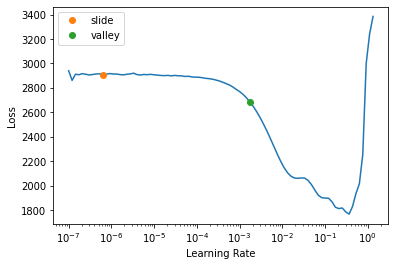

In [59]:
learn.lr_find(suggest_funcs = (slide, valley))

In [60]:
learn.fit(3, 0.003)

epoch,train_loss,valid_loss,mae,time
0,2407.628662,1809.198120,38.383400,00:00
1,1786.631958,734.924927,23.031967,00:00
2,1320.497192,199.912750,10.772133,00:00


In [64]:
y = []
for x in learn.model.parameters():
    y.append(x)
weights = y[1]

In [65]:
def search_similar_items(idx: int, kind: str, all_items = all_items, weights = weights):
  if kind == 'clip':
    item = get_embeds(grouped_df.iloc[idx]['Description']).to(torch_device)
    scores = torch.einsum("abc,dbc->a", all_items.to(torch_device), item)
    return torch.argsort(scores, descending = True)[1:6]
  elif kind == 'dot_nn':
    item = weights[idx]
    scores = ((weights * torch.tensor(item)).sum(dim = 1, keepdim = True)).argsort(axis = 0)[0:5]
    return scores

In [69]:
# TESTING !!!
sample_item_idx = 10
print(idx_to_desc(sample_item_idx))
print("Recommendations using OG Embedding Layers + Feedforward Neural Network", list(idx_to_desc(search_similar_items(sample_item_idx, kind = 'dot_nn'))))
print("Recommendations using CLIP Tokenizer + Embeddings", list(idx_to_desc(search_similar_items(sample_item_idx, kind = 'clip'))))

 TOADSTOOL BEDSIDE LIGHT 
Recommendations using OG Embedding Layers + Feedforward Neural Network ['MINI PAINT SET VINTAGE ', 'CHILDS GARDEN TROWEL PINK', 'PINK POLKADOT KIDS BAG', 'LETTER "W" BLING KEY RING', 'FRENCH CHATEAU OVAL PLATTER']
Recommendations using CLIP Tokenizer + Embeddings ['TOADSTOOL BEDSIDE LIGHT ', 'RED TOADSTOOL LED NIGHT LIGHT', 'TOADSTOOL MONEY BOX', 'FELT TOADSTOOL LARGE', 'FELT TOADSTOOL  SMALL']
